In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# CHEKING DISK STORAGE

In [2]:
import shutil

# Get disk space details
total, used, free = shutil.disk_usage("/")

# Convert to human-readable format
def format_size(size):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024

print(f"Total Space: {format_size(total)}")
print(f"Used Space: {format_size(used)}")
print(f"Free Space: {format_size(free)}")

Total Space: 915.32 GB
Used Space: 726.64 GB
Free Space: 142.12 GB


In [3]:
import os

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            # Add file size, skipping broken symbolic links
            if os.path.exists(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

def print_directory_size(directory):
    size_bytes = get_directory_size(directory)
    # Convert bytes to a human-readable format (KB, MB, GB)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            print(f"Size of '{directory}': {size_bytes:.2f} {unit}")
            break
        size_bytes /= 1024

# Example usage
preprocessed_files_path = "data/train_data/preprocessed_files"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

preprocessed_files_path = "executions"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

Size of 'data/train_data/preprocessed_files': 3.40 GB
Size of 'executions': 14.51 GB


# SPECIFY EXECUTION ID WHOSE STUDY IS ANALYSED

In [4]:
import os

############### EXECUTION SETTINGS ###############

PARENT_EXECUTION_DIR = "executions/unet/tuning-train-test"

############## EXECUTION ID ######################

EXECUTION_ID = 171 # Update ID

execution_dir = os.path.join(PARENT_EXECUTION_DIR, f"id={EXECUTION_ID}")
print()
print(f"Execution to evaluate: {execution_dir}")
print()



Execution to evaluate: executions/unet/tuning-train-test/id=171



# LOAD EXECUTION SETTINGS

In [5]:
import json
import pprint

# Load JSON
info_execution_json_file_path = os.path.join(execution_dir, "info_execution.json")

with open(info_execution_json_file_path, "r") as json_file:
    info_execution = json.load(json_file)

# pprint.pprint(info_execution, sort_dicts=False, width=100)
print(info_execution)
print()

################### DATA SETTINGS #################

DATA_DIR = info_execution["DATA_SETTINGS"]["DATA_DIR"] 
# Directory where the samples (data and labels folders) and the metadata.json file are located.

NUM_WORKERS = info_execution["DATA_SETTINGS"]["NUM_WORKERS"]
# Number of logical CPU Cores used for parallelizing data laoding


{'INFO_EXECUTION': {'PARENT_EXECUTION_DIR': 'executions/unet/tuning-train-test', 'EXECUTION_ID': 171, 'EXECUTION_DIR': 'id=171'}, 'DATA_SETTINGS': {'DATA_DIR': 'data/train_data', 'METADATA_DATASET': 'metadata_37_samples.json', 'K_FOLDS': 6, 'NUM_WORKERS': 4, 'SAMPLES_DATASET': ['R_002', 'R_003', 'R_004', 'R_005', 'R_006', 'R_007', 'R_008', 'R_009', 'R_010', 'R_011', 'R_012', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_005', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_010', 'Z_011', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_017', 'Z_018', 'Z_019', 'Z_020'], 'VALIDATION_SET': ['R_002', 'R_003', 'R_011', 'Z_005', 'Z_008', 'Z_014', 'Z_020'], 'TRAIN_TEST_SPLITS': {'SPLIT_0': {'TRAIN_SET': ['R_004', 'R_005', 'R_007', 'R_008', 'R_009', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_006', 'Z_007', 'Z_009', 'Z_010', 'Z_011', 'Z_012', 'Z_015', 'Z_016', 'Z_018', 'Z_019'], 'TEST_SET': ['R_006', 'R_010', 'R_012',

# LOAD DATA SPLITTING INFO

In [6]:
import json
import os


# Load metadata JSON file
metadata_json_path = os.path.join(info_execution["DATA_SETTINGS"]["DATA_DIR"], info_execution["DATA_SETTINGS"]["METADATA_DATASET"])
with open(metadata_json_path, "r") as f:
    metadata = json.load(f)

# Restore validation files
validation_files_original_copy = {sample: metadata[sample] for sample in info_execution["DATA_SETTINGS"]["VALIDATION_SET"]}

# Restore train-test splits
train_test_splits_orginal_copy = []
for split_key, split_data in info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"].items():
    train_files = {sample: metadata[sample] for sample in split_data["TRAIN_SET"]}
    test_files = {sample: metadata[sample] for sample in split_data["TEST_SET"]}
    train_test_splits_orginal_copy.append((train_files, test_files))

print("✅ Successfully restored `train_test_splits_orginal_copy` and `validation_files_original_copy` from JSON!")

print()
# Pretty-print the configurations
# print("=> Validation Set")
# print()
# pprint.pprint(validation_files_original_copy, sort_dicts=False, width=100)
# print()
# # Pretty-print the configurations
# print("=> Train/Test Splits")
# print()
# pprint.pprint(train_test_splits_orginal_copy, sort_dicts=False, width=100)

✅ Successfully restored `train_test_splits_orginal_copy` and `validation_files_original_copy` from JSON!



# Importing libraries

In [7]:
import os
import json
import time
import shutil
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns  # Used for plotting
from PIL import Image  # Used to save images
from datetime import timedelta, datetime

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import optuna

# Functions needed

In [8]:
import importlib
# Own library
import utils.data_utils
importlib.reload(utils.data_utils)
from utils.data_utils import custom_collate

# Function to apply the viridis colormap and convert to uint8
def apply_colormap_and_normalize(array, cmap, vmin, vmax):
    norm_array = (array - vmin) / (vmax - vmin)  # Normalize to [0, 1]
    norm_array = np.clip(norm_array, 0, 1)  # Clip values to avoid overflow
    colormap = plt.get_cmap(cmap)
    rgba_img = colormap(norm_array)  # Apply colormap, returns RGBA
    rgb_img = (rgba_img[:, :, :3] * 255).astype("uint8")  # Convert to RGB
    return rgb_img

# LOAD HYPERPARAMETER TUNNING STUDY

In [9]:
execution_id = EXECUTION_ID

print(f"(Before releasing CUDA memory) Allocated CUDA memory: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
print(f"(Before releasing CUDA memory) Reserved CUDA memory: {torch.cuda.memory_reserved() / 1e6:.2f} MB")
print()

gc.collect()
torch.cuda.empty_cache()

print(f"(After releasing CUDA memory) Allocated CUDA memory: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
print(f"(After releasing CUDA memory) Reserved CUDA memory: {torch.cuda.memory_reserved() / 1e6:.2f} MB")
print()

# Create the directory
tuning_dir = os.path.join(execution_dir, 'tuning')

study_storage_path = os.path.join("sqlite:///", tuning_dir, f"optuna_study.db")

# load an existing study
study = optuna.load_study(study_name=f"study_id={execution_id}", storage=study_storage_path)
print(f"Optuna study loaded: {study_storage_path}")
print()

(Before releasing CUDA memory) Allocated CUDA memory: 0.00 MB
(Before releasing CUDA memory) Reserved CUDA memory: 0.00 MB

(After releasing CUDA memory) Allocated CUDA memory: 0.00 MB
(After releasing CUDA memory) Reserved CUDA memory: 0.00 MB

Optuna study loaded: sqlite:///executions/unet/tuning-train-test/id=171/tuning/optuna_study.db



# INFO HYPERPARAMETER TUNING

In [10]:
import os
import plotly.io as pio

# Set default renderer for Jupyter Notebook/Lab
pio.renderers.default = 'iframe'

# Visualize results
from optuna.visualization import plot_optimization_history

# Plot optimization history
fig = plot_optimization_history(study)

# Save the plot as an SVG file
svg_file_path = os.path.join(tuning_dir, "optimization_history.svg")
fig.write_image(svg_file_path, format="svg", width=1200, height=800, scale=3)

print(f"Plot saved as an SVG file at: {svg_file_path}")

# Display the plot
plot_optimization_history(study)

Plot saved as an SVG file at: executions/unet/tuning-train-test/id=171/tuning/optimization_history.svg


In [11]:
# Visualize results
from optuna.visualization import plot_param_importances
import os

# Plot parameter importances
fig = plot_param_importances(study)

# Save the plot as an SVG file
svg_file_path = os.path.join(tuning_dir, "param_importances.svg")
fig.write_image(svg_file_path, format="svg", width=1500, height=800, scale=3)

print(f"Plot saved as an SVG file at: {svg_file_path}")

# Display the plot
plot_param_importances(study)

Plot saved as an SVG file at: executions/unet/tuning-train-test/id=171/tuning/param_importances.svg


Study's trials state info plot saved at: executions/unet/tuning-train-test/id=171/tuning/trials_state_info_study.svg


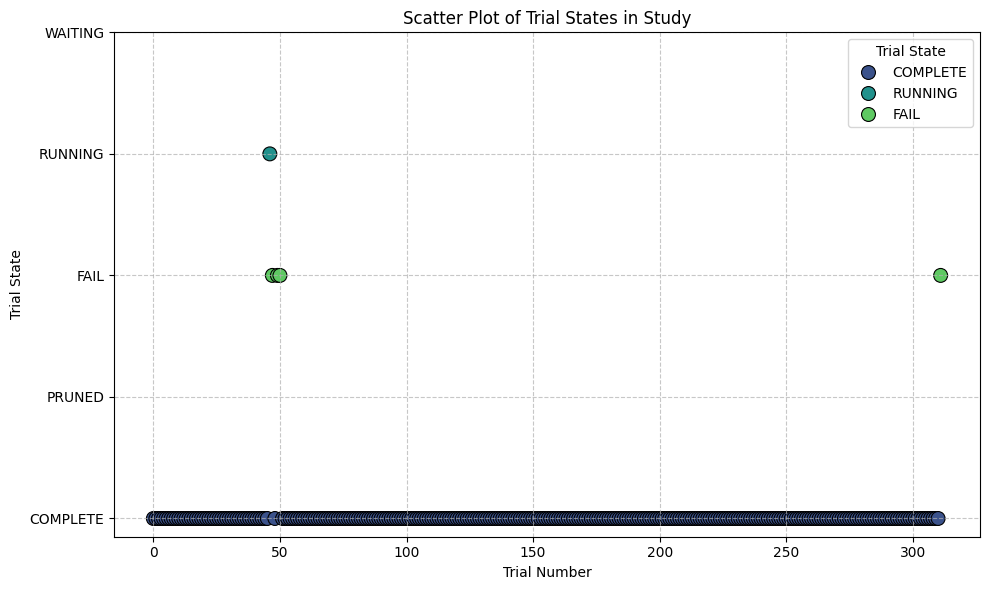

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Example data: Map trial states to numeric values
trial_states = [trial.state.name for trial in study.trials]
trial_numbers = range(len(study.trials))
state_mapping = {"COMPLETE": 1, "PRUNED": 2, "FAIL": 3, "RUNNING": 4, "WAITING": 5}
mapped_states = [state_mapping.get(state, 0) for state in trial_states]

# Create a DataFrame for plotting
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Mapped State": mapped_states,
    "Trial State": trial_states
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="Trial Number",
    y="Mapped State",
    hue="Trial State",  # Add hue for categorical coloring
    palette="viridis",  # Use the Viridis colormap
    s=100,              # Marker size
    edgecolor="k"       # Black edges around markers
)

# Adjust y-axis ticks to display state names
plt.yticks(list(state_mapping.values()), list(state_mapping.keys()))

# Add title, labels, and grid
plt.xlabel("Trial Number")
plt.ylabel("Trial State")
plt.title("Scatter Plot of Trial States in Study")
plt.grid(True, linestyle="--", alpha=0.7)

# Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "trials_state_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Study's trials state info plot saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Study's temporal info plot saved at: executions/unet/tuning-train-test/id=171/tuning/trial_state_aggregate_count_info_study.svg


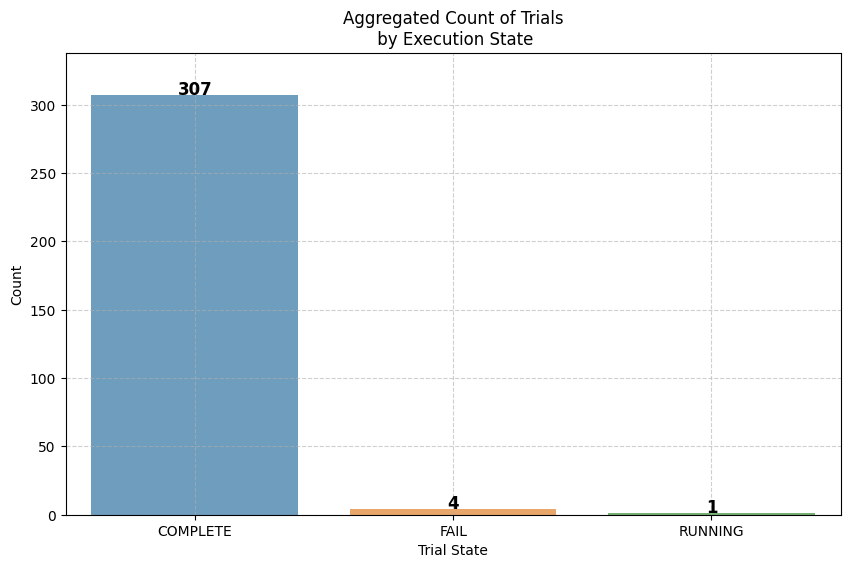

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os

# Recalculate trial_counts if not already defined
trial_states = [trial.state.name for trial in study.trials]
trial_counts = pd.DataFrame(trial_states, columns=["Trial State"]).value_counts().reset_index()
trial_counts.columns = ["Trial State", "Count"]


# Create the plot with different colors for each state
plt.figure(figsize=(10, 6))
sns.barplot(
    data=trial_counts,
    x="Trial State",
    y="Count",
    hue="Trial State",  # Different colors for each state
    dodge=False,  # Ensure only one bar per state
    alpha=0.7
)

plt.title("Aggregated Count of Trials\n by Execution State")
plt.grid(linestyle="--", alpha=0.6)

# Adjust y-axis limits to make space for annotations
max_count = trial_counts["Count"].max()
plt.ylim(0, max_count + math.ceil(max_count * 0.1))  # Add 10% margin above the tallest bar

# Display values on top of each bar
for index, row in trial_counts.iterrows():
    plt.text(
        index, 
        row["Count"] + 0.4, 
        str(row["Count"]), 
        ha="center", 
        fontsize=12, 
        fontweight="bold"
    )


# Save the plot in vectorial formats (SVG and PDF)
svg_path = os.path.join(tuning_dir, f"trial_state_aggregate_count_info_study.svg")
plt.savefig(svg_path, format="svg", bbox_inches="tight")

print(f"Study's temporal info plot saved at: {svg_path}")

# Show the plot
plt.show()


Total Study Runtime: 7 days, 7:35:03.854850
Average Trial Duration: 0:29:38.608635
Minimum Trial Duration: 0:00:00.143003
Maximum Trial Duration: 2:08:18.761987
Total Time for COMPLETE: 6 days, 9:37:59.751574
Total Time for FAIL: 0:01:07.533849
Study's temporal info plot saved at: executions/unet/tuning-train-test/id=171/tuning/temporal_info_study.svg


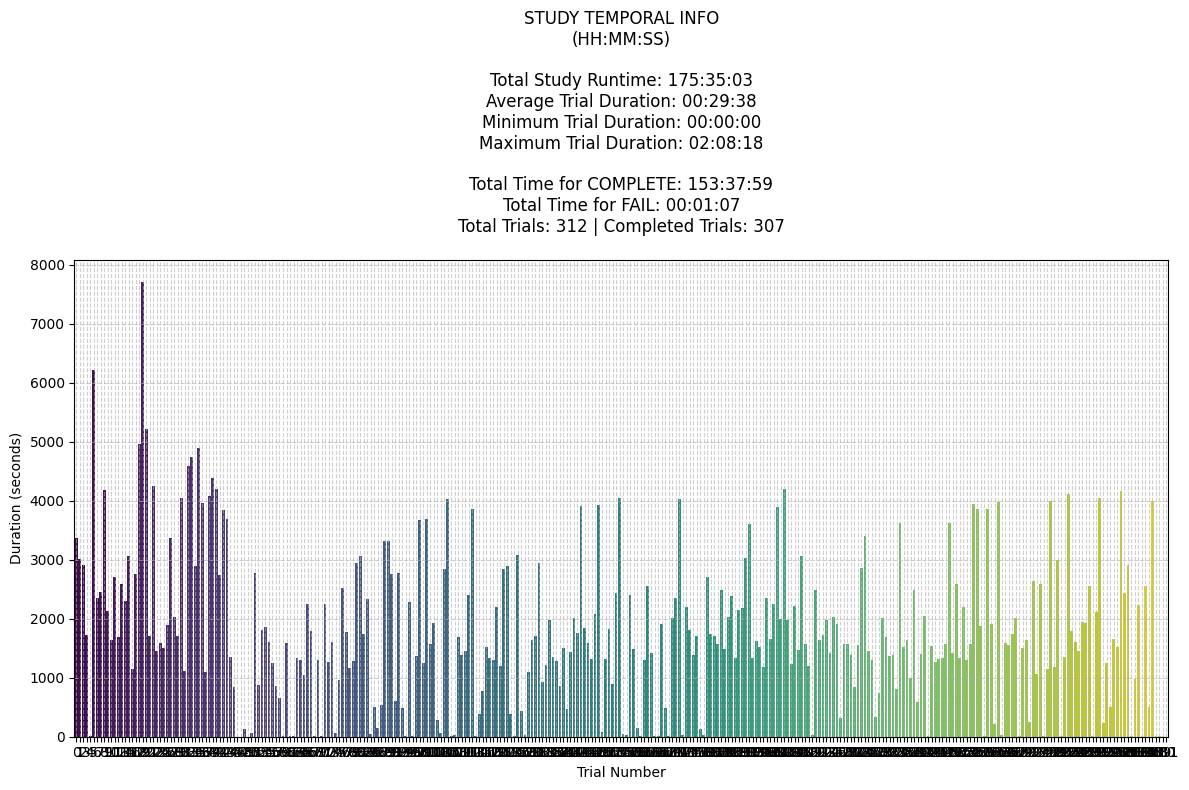

In [14]:
from datetime import timedelta, datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Study-Level Statistics
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)
total_study_runtime = study_end_time - study_start_time

print(f"Total Study Runtime: {total_study_runtime}")

# Trial-Level Statistics
trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in study.trials
    if trial.datetime_start and trial.datetime_complete
]

if trial_durations:
    avg_duration = sum(trial_durations, timedelta()) / len(trial_durations)
    min_duration = min(trial_durations)
    max_duration = max(trial_durations)

    print(f"Average Trial Duration: {avg_duration}")
    print(f"Minimum Trial Duration: {min_duration}")
    print(f"Maximum Trial Duration: {max_duration}")
else:
    print("No completed trials to calculate durations.")

# Time by Trial State
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

state_info_str = ""
for state, total_duration in state_durations.items():
    state_info = f"Total Time for {state.name}: {total_duration}"
    print(state_info)
    state_info_str += state_info + "\n"

# Visualize Trial Durations
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# Convert timedelta objects to HH:MM:SS format
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Format times
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Create DataFrame for Seaborn
data = {
    "Trial Number": trial_numbers,
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Trial Number",
    y="Duration (seconds)",
    hue="Trial Number",  # Use hue to map colors
    dodge=False,  # Prevent multiple bars for each hue
    palette="viridis",  # Apply the color palette
    legend=False        # Hide the legend since it is unnecessary
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
title_text = (
    "STUDY TEMPORAL INFO\n(HH:MM:SS)\n\n"
    f"Total Study Runtime: {formatted_total_runtime}\n"
    f"Average Trial Duration: {formatted_avg_duration}\n"
    f"Minimum Trial Duration: {formatted_min_duration}\n"
    f"Maximum Trial Duration: {formatted_max_duration}\n\n"
    f"{state_info_str}\n"
    f"Total Trials: {len(study.trials)} | Completed Trials: {len(completed_trials)}"
)
plt.title(title_text, loc="center", pad=20)
plt.grid(linestyle="--", alpha=0.6)

# Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "temporal_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Study's temporal info plot saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()

Total Study Runtime: 7 days, 7:35:03.854850
Average Completed Trial Duration: 0:30:01.562709
Minimum Completed Trial Duration: 0:00:05.170671
Maximum Completed Trial Duration: 2:08:18.761987
Total Time for COMPLETE: 6 days, 9:37:59.751574
Total Time for FAIL: 0:01:07.533849
Study's temporal info plot saved at: executions/unet/tuning-train-test/id=171/tuning/temporal_info_study.svg


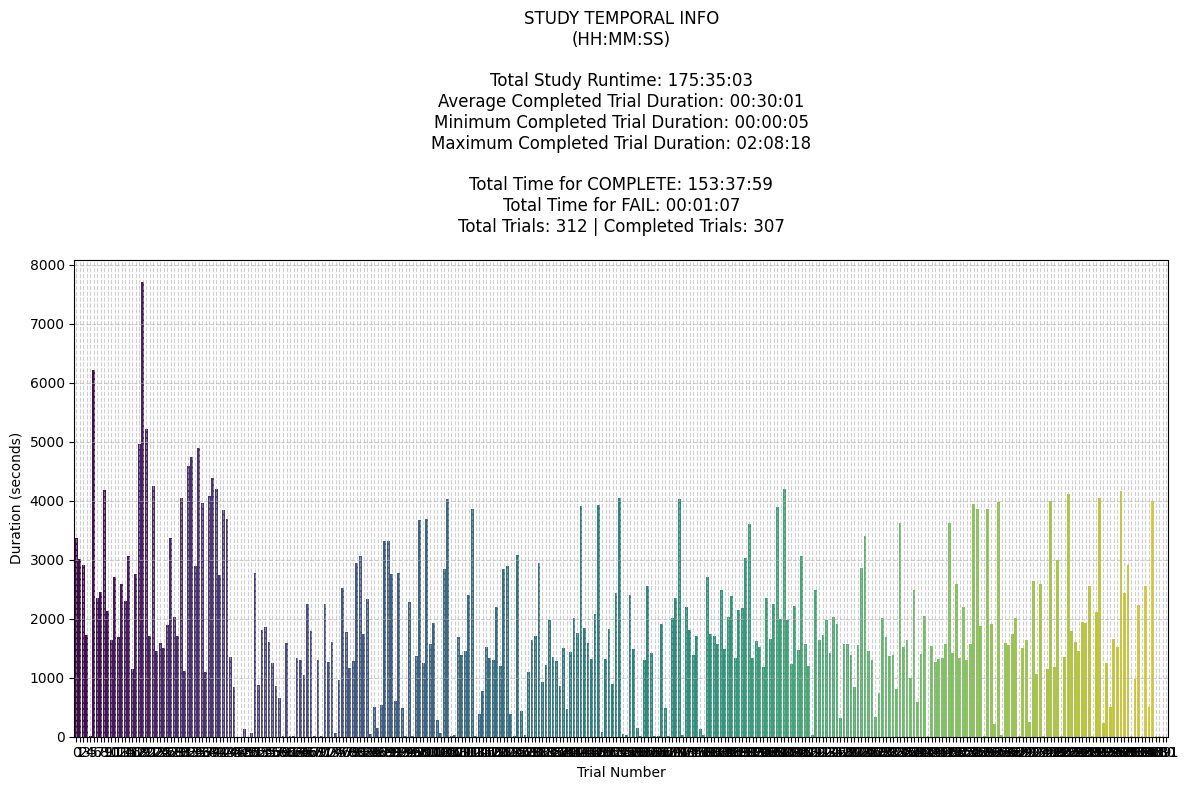

In [15]:
from datetime import timedelta, datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# Study-Level Statistics
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)
total_study_runtime = study_end_time - study_start_time

print(f"Total Study Runtime: {total_study_runtime}")

# Filter only completed trials
completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]

# Trial-Level Statistics (Only for Completed Trials)
completed_trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in completed_trials
    if trial.datetime_start and trial.datetime_complete
]

if completed_trial_durations:
    avg_duration = sum(completed_trial_durations, timedelta()) / len(completed_trial_durations)
    min_duration = min(completed_trial_durations)
    max_duration = max(completed_trial_durations)

    print(f"Average Completed Trial Duration: {avg_duration}")
    print(f"Minimum Completed Trial Duration: {min_duration}")
    print(f"Maximum Completed Trial Duration: {max_duration}")
else:
    print("No completed trials to calculate durations.")
    avg_duration = min_duration = max_duration = timedelta(0)  # Default to zero if no trials are completed

# Time by Trial State
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

state_info_str = ""
for state, total_duration in state_durations.items():
    state_info = f"Total Time for {state.name}: {total_duration}"
    print(state_info)
    state_info_str += state_info + "\n"

# Visualize Trial Durations
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# Convert timedelta objects to HH:MM:SS format
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Format times (Only for Completed Trials)
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)

# Create DataFrame for Seaborn
data = {
    "Trial Number": trial_numbers,
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Trial Number",
    y="Duration (seconds)",
    hue="Trial Number",  # Use hue to map colors
    dodge=False,  # Prevent multiple bars for each hue
    palette="viridis",  # Apply the color palette
    legend=False        # Hide the legend since it is unnecessary
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
title_text = (
    "STUDY TEMPORAL INFO\n(HH:MM:SS)\n\n"
    f"Total Study Runtime: {formatted_total_runtime}\n"
    f"Average Completed Trial Duration: {formatted_avg_duration}\n"
    f"Minimum Completed Trial Duration: {formatted_min_duration}\n"
    f"Maximum Completed Trial Duration: {formatted_max_duration}\n\n"
    f"{state_info_str}\n"
    f"Total Trials: {len(study.trials)} | Completed Trials: {len(completed_trials)}"
)
plt.title(title_text, loc="center", pad=20)
plt.grid(linestyle="--", alpha=0.6)

# Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "temporal_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Study's temporal info plot saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Histogram of trial durations saved at: executions/unet/tuning-train-test/id=171/tuning/trial_duration_histogram.svg


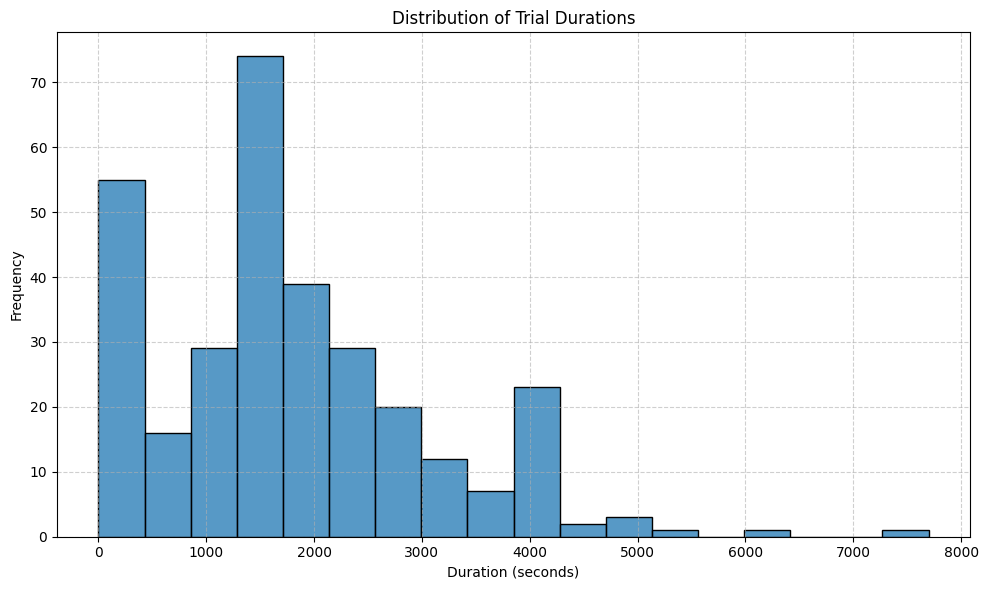

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create DataFrame for durations
data = {
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="Duration (seconds)",
)

# Add labels and title
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title(
    "Distribution of Trial Durations",
    loc="center"
)
plt.grid(linestyle="--", alpha=0.6)

# Save the histogram in SVG format
histogram_path_svg = os.path.join(tuning_dir, "trial_duration_histogram.svg")
plt.savefig(histogram_path_svg, format="svg", bbox_inches="tight")
print(f"Histogram of trial durations saved at: {histogram_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Bar plot of CUDA memory usage saved at: executions/unet/tuning-train-test/id=171/tuning/cuda_memory_usage_info_study.svg


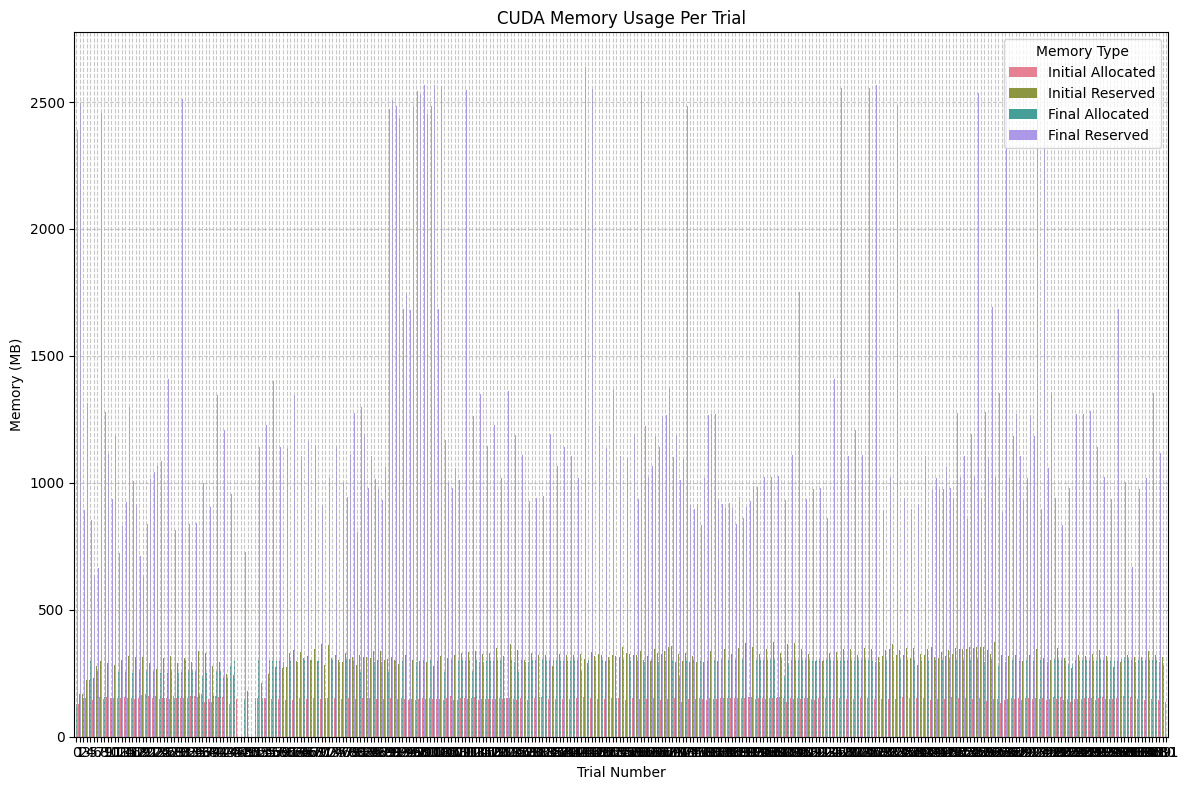

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Extract data for plotting
trial_numbers = list(range(0, len(study.trials)))
initial_allocated = [trial.user_attrs["initial_allocated_cuda_memory"] for trial in study.trials if "initial_allocated_cuda_memory" in trial.user_attrs]
initial_reserved = [trial.user_attrs["initial_reserved_cuda_memory"] for trial in study.trials if "initial_reserved_cuda_memory" in trial.user_attrs]
final_allocated = [trial.user_attrs["final_allocated_cuda_memory"] for trial in study.trials if "final_allocated_cuda_memory" in trial.user_attrs]
final_reserved = [trial.user_attrs["final_reserved_cuda_memory"] for trial in study.trials if "final_reserved_cuda_memory" in trial.user_attrs]

# Prepare the data for Seaborn
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved,
})

# Melt the data for easier plotting with Seaborn
data_melted = data.melt(id_vars="Trial Number", 
                        var_name="Memory Type", 
                        value_name="Memory (MB)")

# Plot the bar chart using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=data_melted,
    x="Trial Number",
    y="Memory (MB)",
    hue="Memory Type",
    dodge=True,  # Ensure separate bars for each memory type
    palette="husl"  # Color palette
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Memory (MB)")
plt.title("CUDA Memory Usage Per Trial")
plt.legend(title="Memory Type", loc="upper right")
plt.grid(linestyle="--", alpha=0.7)

# Save the plot as an SVG file
plot_path_svg = os.path.join(tuning_dir, f"cuda_memory_usage_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Bar plot of CUDA memory usage saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Histogram for Initial Allocated saved at: executions/unet/tuning-train-test/id=171/tuning/initial_allocated_memory_usage_histogram.svg


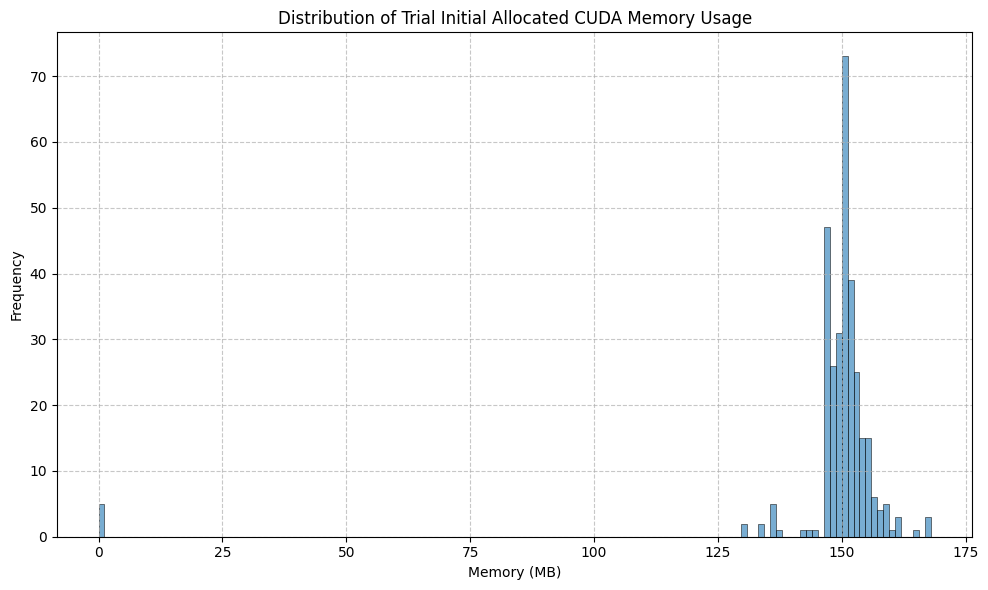

Histogram for Initial Reserved saved at: executions/unet/tuning-train-test/id=171/tuning/initial_reserved_memory_usage_histogram.svg


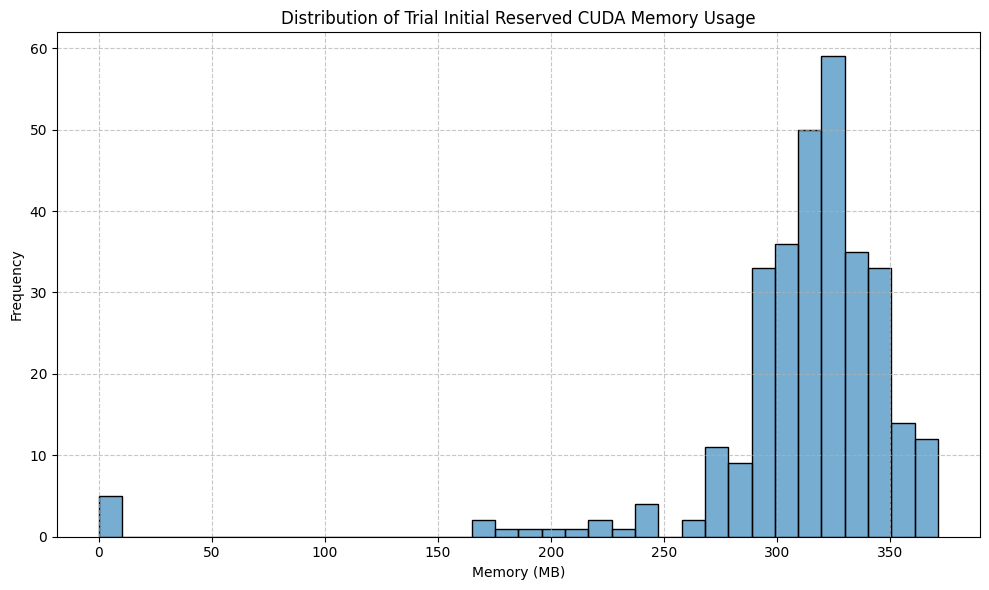

Histogram for Final Allocated saved at: executions/unet/tuning-train-test/id=171/tuning/final_allocated_memory_usage_histogram.svg


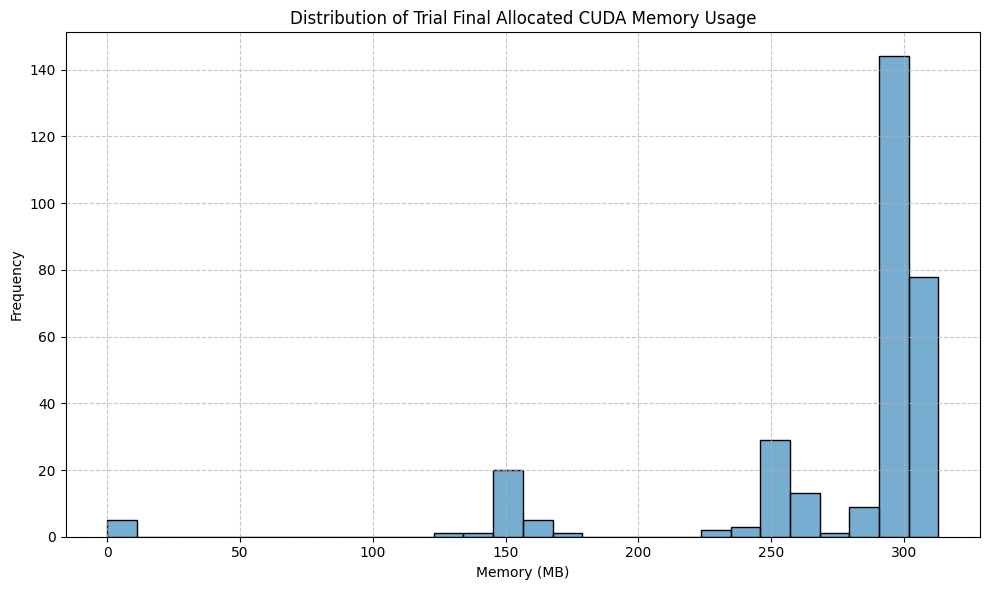

Histogram for Final Reserved saved at: executions/unet/tuning-train-test/id=171/tuning/final_reserved_memory_usage_histogram.svg


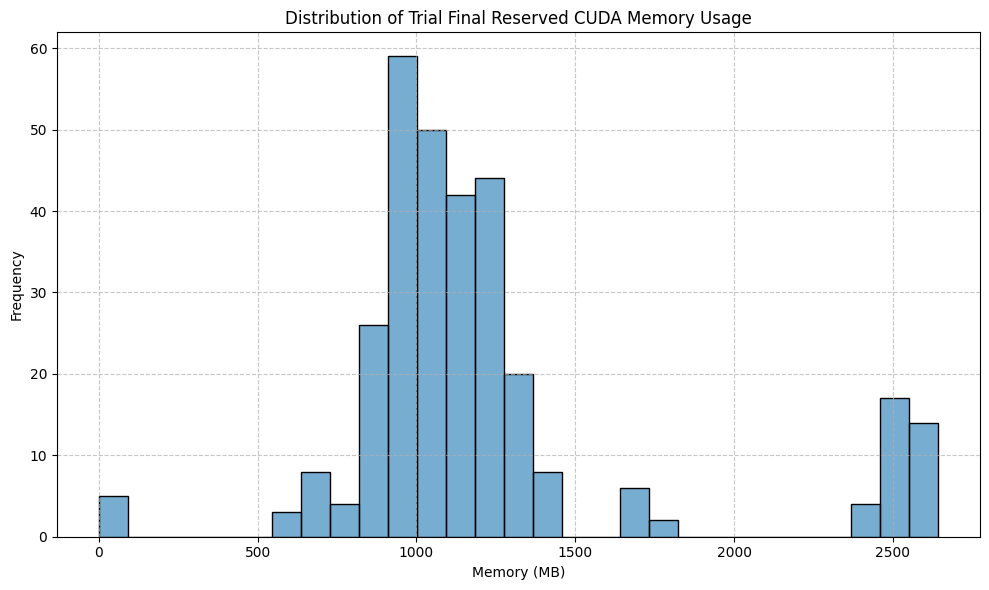

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Extract data for plotting
initial_allocated = [trial.user_attrs["initial_allocated_cuda_memory"] for trial in study.trials if "initial_allocated_cuda_memory" in trial.user_attrs]
initial_reserved = [trial.user_attrs["initial_reserved_cuda_memory"] for trial in study.trials if "initial_reserved_cuda_memory" in trial.user_attrs]
final_allocated = [trial.user_attrs["final_allocated_cuda_memory"] for trial in study.trials if "final_allocated_cuda_memory" in trial.user_attrs]
final_reserved = [trial.user_attrs["final_reserved_cuda_memory"] for trial in study.trials if "final_reserved_cuda_memory" in trial.user_attrs]

# Combine the data into a dictionary for convenience
data = {
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved
}

# Create separate histograms for each memory type
for label, values in data.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(
        values,
        alpha=0.6
    )
    
    # Add labels and title
    plt.xlabel("Memory (MB)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Trial {label} CUDA Memory Usage")
    plt.grid(linestyle="--", alpha=0.7)

    # Save the plot in SVG format
    plot_path_svg = os.path.join(tuning_dir, f"{label.lower().replace(' ', '_')}_memory_usage_histogram.svg")
    plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
    print(f"Histogram for {label} saved at: {plot_path_svg}")

    # Show the plot
    plt.tight_layout()
    plt.show()


Dual bar plot saved at: executions/unet/tuning-train-test/id=171/tuning/model_params_flops_study_bar.svg


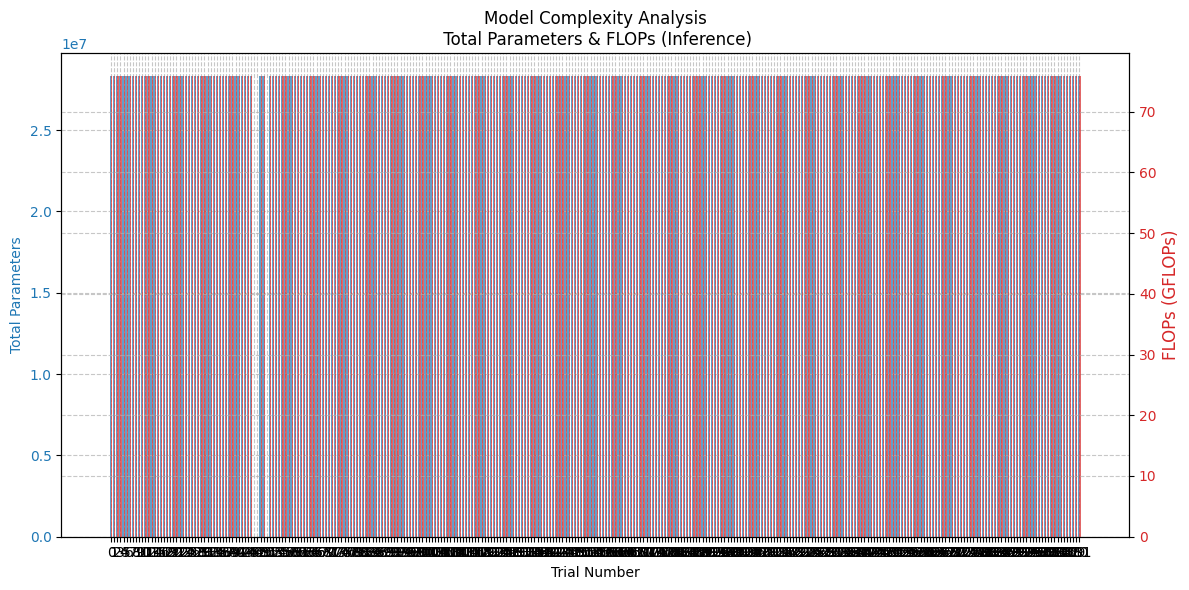

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Extract data for plotting
trial_numbers = list(range(0, len(study.trials)))
total_params = [trial.user_attrs["model_total_params"] for trial in study.trials if "model_total_params" in trial.user_attrs]
flops_inference = [trial.user_attrs["model_gflops_inference"] for trial in study.trials if "model_gflops_inference" in trial.user_attrs]

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar width for better visualization
bar_width = 0.4

# Bar positions
x_indices_params = np.arange(len(total_params))
x_indices_flops = x_indices_params + bar_width

# Plot total parameters as bars
color = 'tab:blue'
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Total Parameters", color=color)
ax1.bar(x_indices_params, total_params, width=bar_width, label="Total Parameters", color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='--', alpha=0.7)

# Second y-axis for FLOPs
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("FLOPs (GFLOPs)", color=color, fontsize=12)
ax2.bar(x_indices_flops, flops_inference, width=bar_width, label="FLOPs (GFLOPs)", color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(linestyle='--', alpha=0.7)

# Adjust x-axis ticks to align with bars
ax1.set_xticks(x_indices_params + bar_width / 2)
ax1.set_xticklabels([f"{i}" for i in range(len(total_params))])

# Add title
plt.title("Model Complexity Analysis\n Total Parameters & FLOPs (Inference)")

# Adjust layout for better spacing
fig.tight_layout()

# Save the plot as an SVG file
plot_path_svg = os.path.join(tuning_dir, f"model_params_flops_study_bar.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Dual bar plot saved at: {plot_path_svg}")

# Show the plot
plt.show()


# BEST TRIAL

## Summary

In [20]:
best_trial_model_info = {
    "model_total_params": study.best_trial.user_attrs["model_total_params"],
    "model_trainable_params": study.best_trial.user_attrs["model_trainable_params"],
    "model_non_trainable_params": study.best_trial.user_attrs["model_non_trainable_params"],
    "model_gflops_inference": study.best_trial.user_attrs["model_gflops_inference"] # IN GFLOPS
}

best_trial_training_config={
    "lr_optimizer": study.best_trial.params["lr_optimizer"],
    "weight_decay_optimizer": study.best_trial.params["weight_decay_optimizer"],
    "optimizer": study.best_trial.params["optimizer"],
    "max_training_epochs": study.best_trial.params["max_training_epochs"],
    "patience_epochs_early_stopping": study.best_trial.params["patience_epochs_early_stopping"],
    "batch_size": study.best_trial.params["batch_size"],
    "pre_processing_technique": study.best_trial.params["pre_processing_technique"],
    "pre_processing_channels": 10
}

# Combine all configs into a single dictionary
best_trial_config = {
    "TRIAL_ID": study.best_trial.number,
    "VAL_LOSS": study.best_trial.value,
    "MODEL_INFO": best_trial_model_info,
    "TRAINING_CONFIG": best_trial_training_config,
}

# Generate JSON with best trial's hyperparameter config
info_best_trial_json_file_path = os.path.join(tuning_dir, "best_trial", "best_trial_summary_info.json")
with open(info_best_trial_json_file_path, "w") as json_file:
    json.dump(best_trial_config, json_file, indent=4)
print(f"Best trial config JSON file successfully generated at: {info_best_trial_json_file_path}")

print()
print(f"{'=' * 50}")
print(f"{'=' * 18} BEST TRIAL: {study.best_trial.number} {'=' * 17}")
print(f"{'=' * 16} Val. Loss: {study.best_trial.value:.4f} {'=' * 16}")
print(f"{'=' * 50}")
print()

print(f"Total Parameters: {study.best_trial.user_attrs['model_total_params']}")
print(f"Trainable Parameters: {study.best_trial.user_attrs['model_trainable_params']}")
print(f"Non-Trainable Parameters: {study.best_trial.user_attrs['model_non_trainable_params']}")
print(f"FLOPs: {study.best_trial.user_attrs['model_gflops_inference'] :.3f} GFLOPs")

print()
print()

# Pretty-print the configurations
pprint.pprint(best_trial_config, sort_dicts=False, width=100)

print()

Best trial config JSON file successfully generated at: executions/unet/tuning-train-test/id=171/tuning/best_trial/best_trial_summary_info.json

================== BEST TRIAL: 299 =================
================ Val. Loss: 0.1303 ================

Total Parameters: 28318466
Trainable Parameters: 28318466
Non-Trainable Parameters: 0
FLOPs: 75.842 GFLOPs


{'TRIAL_ID': 299,
 'VAL_LOSS': 0.1303325593471527,
 'MODEL_INFO': {'model_total_params': 28318466,
                'model_trainable_params': 28318466,
                'model_non_trainable_params': 0,
                'model_gflops_inference': 75.842077696},
 'TRAINING_CONFIG': {'lr_optimizer': 0.0033250234238817035,
                     'weight_decay_optimizer': 0.00010179319024552697,
                     'optimizer': 'adam',
                     'max_training_epochs': 3000,
                     'patience_epochs_early_stopping': 578,
                     'batch_size': 8,
                     'pre_processing_technique': 'ppt',
       

## Validation Results (Ground Truth vs Prediction)

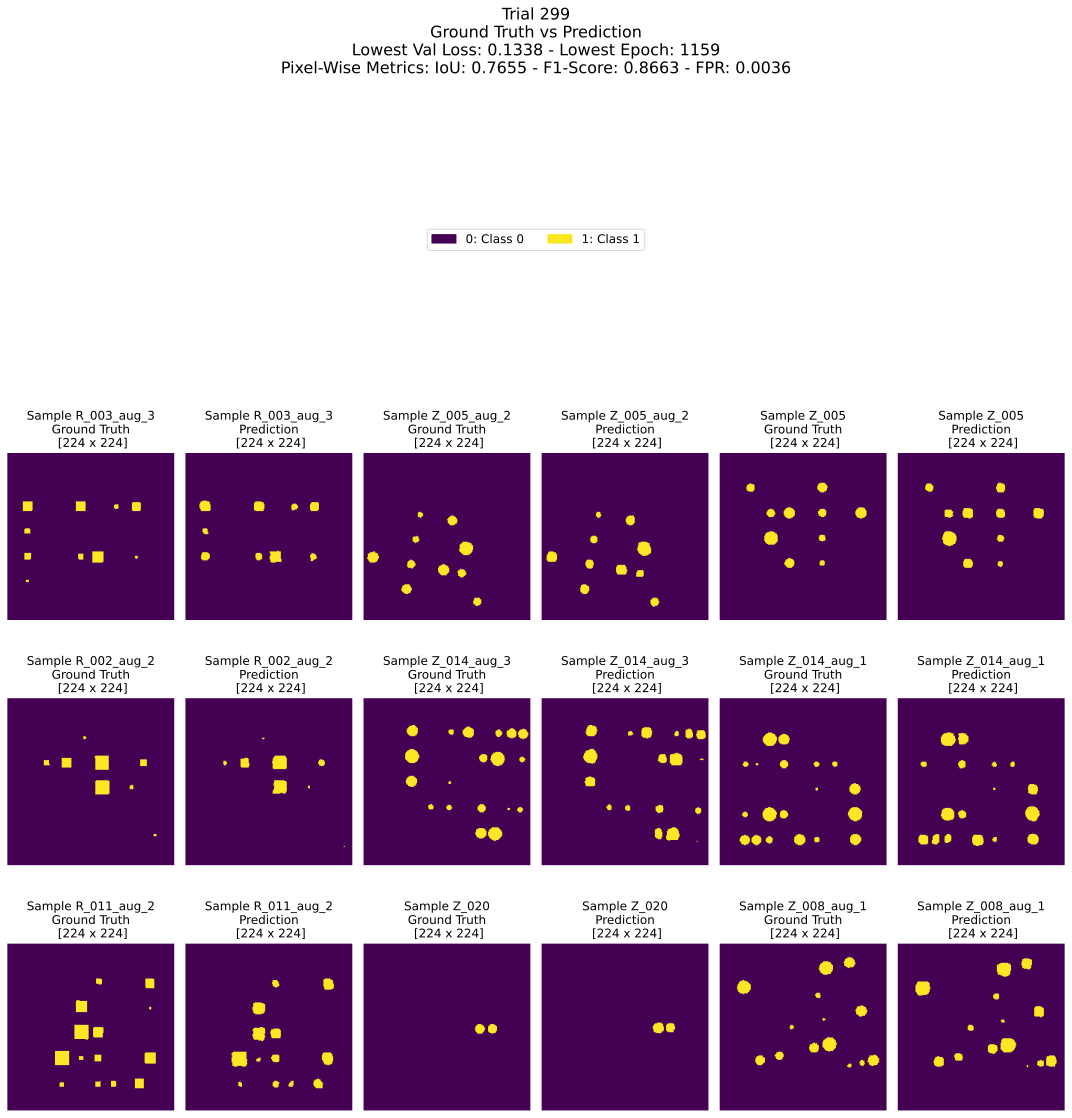

In [21]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"validation_gt_vs_pred.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path

## Training vs Validation Loss Evolution

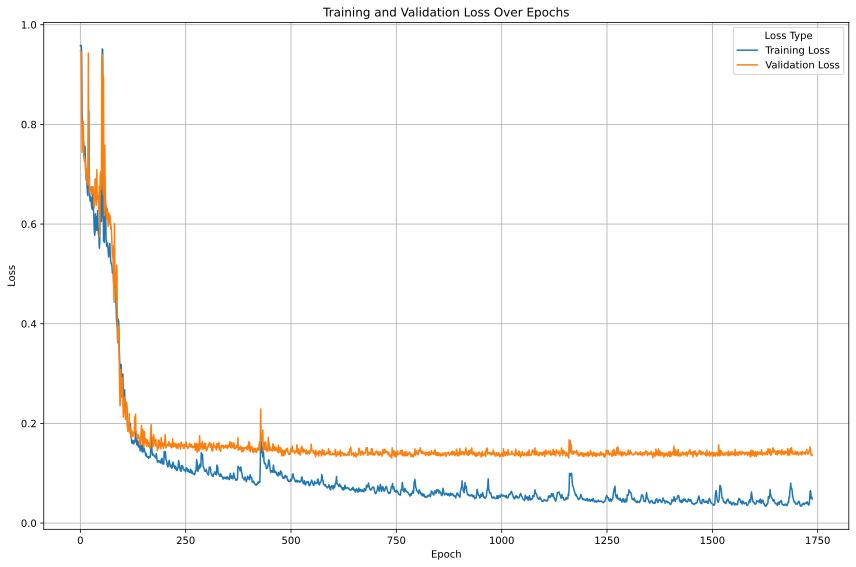

In [22]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"train_val_loss_evolution.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path